In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter

In [2]:
def repeat_last(l):
    l = np.array(l)
    return np.append(l, [l[-1]])

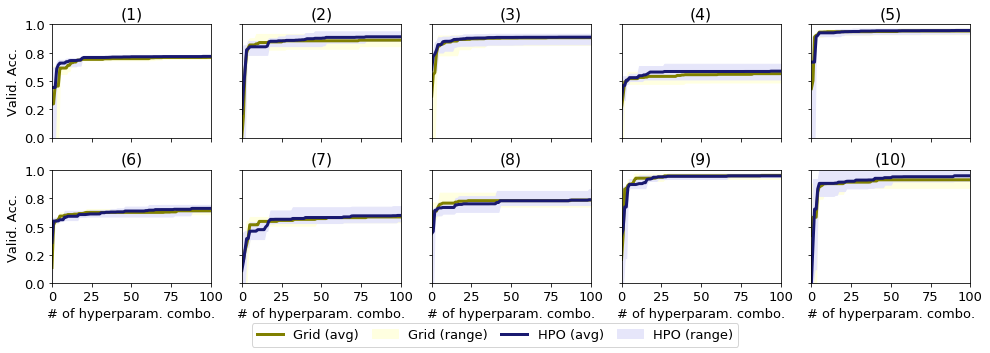

In [3]:
plt.rcParams.update({'font.size':13})

dist = 'normal'

ylim = [0, 1]

fig, axs = plt.subplots(2, 5, figsize=(14, 5))
idx = 0
for dataset_id, dataset in enumerate(['ATAC_JV_adipose','CTCF_TDH_ENCODE','H3K27ac-H3K4me3_TDHAM_BP',
                            'H3K27ac_TDH_some','H3K36me3_AM_immune','H3K27me3_RL_cancer',
                            'H3K27me3_TDH_some','H3K36me3_TDH_ENCODE','H3K36me3_TDH_immune',
                            'H3K36me3_TDH_other']):
    ax = axs[idx // 5][idx % 5]
    idx += 1
    
    s = {}
    for fold in [1, 2, 3, 4]:
        with open(f'./{dataset}/grid-{dist}-fold{fold}.json', 'r') as f:
            obj = json.load(f)
        s[fold] = [x for _, x in sorted(zip(obj['timestamp'], obj['cv_accuracy']), key=lambda x : x[0])]
        s[fold] = np.maximum.accumulate(s[fold])
    df = pd.DataFrame(s)
    n = len(df) + 1
    ax.fill_between(np.arange(n), repeat_last(df.min(axis=1)), repeat_last(df.max(axis=1)), color='lightyellow', label='Grid (range)')
    ax.plot(np.arange(n), repeat_last(df.mean(axis=1)), 'olive', label='Grid (avg)', linewidth=3)
    
    s = {}
    for fold in [1, 2, 3, 4]:
        with open(f'./{dataset}/tpe-{dist}-fold{fold}.json', 'r') as f:
            obj = json.load(f)
        s[fold] = [x for _, x in sorted(zip(obj['timestamp'], obj['cv_accuracy']), key=lambda x : x[0])]
        s[fold] = np.maximum.accumulate(s[fold])
    df = pd.DataFrame(s)
    n = len(df) + 1
    ax.fill_between(np.arange(n), repeat_last(df.min(axis=1)), repeat_last(df.max(axis=1)), color='lavender', label='HPO (range)')
    ax.plot(np.arange(n), repeat_last(df.mean(axis=1)), 'midnightblue', label='HPO (avg)', linewidth=3)

    ax.set_title(f'({dataset_id + 1})')
    ax.set_xlim([0, len(df)])
    ax.set_ylim(ylim)
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xlabel('# of hyperparam. combo.')
    ax.set_ylabel('Valid. Acc.')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

for ax in axs.flat:
    ax.label_outer()

handles, labels = ax.get_legend_handles_labels()
hl = sorted(zip(handles, labels), key=lambda x : x[1])
handles, labels = zip(*hl)
fig.legend(handles, labels, loc='lower center', ncol=6, columnspacing=1.0)
fig.tight_layout(rect=[0, 0.05, 1, 1], w_pad=-0.2, h_pad=0.5)

plt.savefig(f'./hyperparam_progress.pdf', dpi=150)

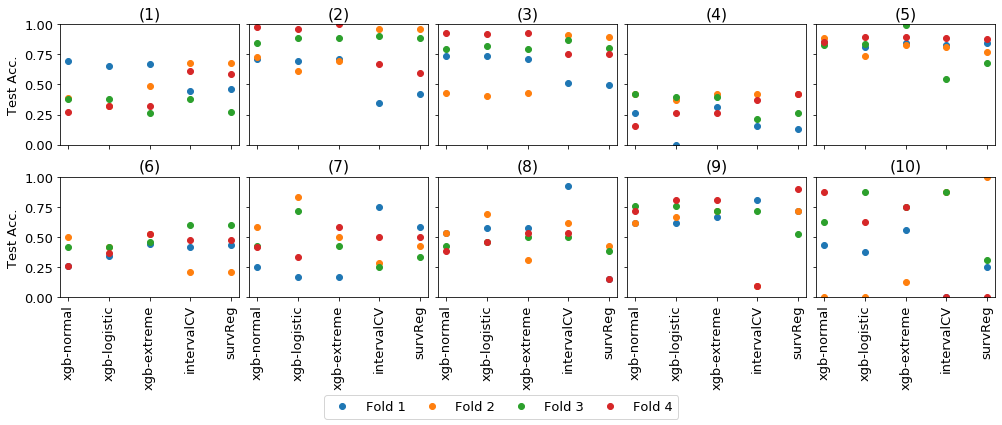

In [4]:
plt.rcParams.update({'font.size':13})

fig, axs = plt.subplots(2, 5, figsize=(14, 6))
idx = 0

ylim = [0, 1]

for dataset_id, dataset in enumerate(['ATAC_JV_adipose','CTCF_TDH_ENCODE','H3K27ac-H3K4me3_TDHAM_BP',
                            'H3K27ac_TDH_some','H3K36me3_AM_immune','H3K27me3_RL_cancer',
                            'H3K27me3_TDH_some','H3K36me3_TDH_ENCODE','H3K36me3_TDH_immune',
                            'H3K36me3_TDH_other']):
    ax = axs[idx // 5][idx % 5]
    idx += 1
    
    scatter_x = {}
    scatter_y = {}
    for fold in [1, 2, 3, 4]:
        scatter_x[fold] = []
        scatter_y[fold] = []
    
    for dist_id, dist in enumerate(['normal', 'logistic', 'extreme']):
        for fold in [1, 2, 3, 4]:
            with open(f'./{dataset}/tpe-{dist}-fold{fold}.json', 'r') as f:
                obj = json.load(f)
            scatter_x[fold].append(dist_id)
            scatter_y[fold].append(obj['final_accuracy'][1])
            
    with open(f'./intervalCV_result/{dataset}/accuracy.JSON', 'r') as f:
        obj = json.load(f)
        for fold in [1, 2, 3, 4]:
            scatter_x[fold].append(3)
            scatter_y[fold].append(obj[str(fold)])
    with open(f'./survreg_result/{dataset}/accuracy.JSON', 'r') as f:
        obj = json.load(f)
        for fold in [1, 2, 3, 4]:
            scatter_x[fold].append(4)
            scatter_y[fold].append(obj[str(fold)])
    for fold in [1, 2, 3, 4]:
        ax.plot(scatter_x[fold], scatter_y[fold], 'o', label=f'Fold {fold}')
    ax.set_title(f'({dataset_id + 1})')
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['xgb-normal', 'xgb-logistic', 'xgb-extreme', 'intervalCV', 'survReg'],
                       rotation='vertical')
    ax.set_ylabel('Test Acc.')
    ax.set_ylim(ylim)

for ax in axs.flat:
    ax.label_outer()

handles, labels = ax.get_legend_handles_labels()
hl = sorted(zip(handles, labels), key=lambda x : x[1])
handles, labels = zip(*hl)
fig.legend(handles, labels, loc='lower center', ncol=4, columnspacing=1.0)
fig.tight_layout(rect=[0, 0.05, 1, 1], w_pad=0.5, h_pad=0.5)

plt.savefig(f'./test_acc_comparison.pdf', dpi=150)